<a href="https://colab.research.google.com/github/jkcopas/DataScienceModalMais/blob/main/Modulo_5_Modelagem_Classifica%C3%A7%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Science com Python

### Módulo 5 - Modelagem Classificação

***Professor: Lucas Roberto Correa***

LEMBRETE: Fazer o import dos datasets usados no ambiente do colab antes de executar os comandos.

### Import dos pacotes

In [1]:
# Manipulação dados
import pandas as pd

# Visualização de dados
import seaborn as sns
import matplotlib.pyplot as plt

# Quebrar os dados
from sklearn.model_selection import train_test_split

# Feature selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler

# Modelos de classificação
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Validação cruzada
from sklearn.model_selection import cross_val_score

# Metricas
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve, auc

# Tuning de hiperparametros
from sklearn.model_selection import GridSearchCV

In [2]:
# adicionar paramwtros de visualização
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

#### Import dos metadados

link da base: https://www.kaggle.com/rashmiranu/banking-dataset-classification?select=new_train.csv

In [3]:
meta = pd.read_excel('metadata.xlsx')

In [4]:
meta

,Feature,Feature_Type,Description
0,age,numeric,age of a person
1,job,"Categorical,nominal","type of job ('admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')"
2,marital,"categorical,nominal","marital status ('divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)"
3,education,"categorical,nominal","('basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')"
4,default,"categorical,nominal","has credit in default? ('no','yes','unknown')"
5,housing,"categorical,nominal","has housing loan? ('no','yes','unknown')"
6,loan,"categorical,nominal","has personal loan? ('no','yes','unknown')"
7,contact,"categorical,nominal","contact communication type ('cellular','telephone')"
8,month,"categorical,ordinal","last contact month of year ('jan', 'feb', 'mar', …, 'nov', 'dec')"
9,dayofweek,"categorical,ordinal","last contact day of the week ('mon','tue','wed','thu','fri')"


#### Import da base

In [5]:
df = pd.read_csv('new_train.csv', sep=',')

In [6]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,y
0,49,blue-collar,married,basic.9y,unknown,no,no,cellular,nov,wed,227,4,999,0,nonexistent,no
1,37,entrepreneur,married,university.degree,no,no,no,telephone,nov,wed,202,2,999,1,failure,no
2,78,retired,married,basic.4y,no,no,no,cellular,jul,mon,1148,1,999,0,nonexistent,yes
3,36,admin.,married,university.degree,no,yes,no,telephone,may,mon,120,2,999,0,nonexistent,no
4,59,retired,divorced,university.degree,no,no,no,cellular,jun,tue,368,2,999,0,nonexistent,no


#### Feature engineering - Criando novas variáveis

In [7]:
df.corr()

,age,duration,campaign,pdays,previous
age,1.000000,-0.001841,0.003302,-0.032011,0.020670
duration,-0.001841,1.000000,-0.075663,-0.047127,0.022538
campaign,0.003302,-0.075663,1.000000,0.053795,-0.079051
pdays,-0.032011,-0.047127,0.053795,1.000000,-0.589601
previous,0.020670,0.022538,-0.079051,-0.589601,1.000000


In [8]:
df['poutcome'].value_counts()

nonexistent    28416
failure         3429
success         1105
Name: poutcome, dtype: int64

In [9]:
df['previous'].value_counts()

0    28416
1     3673
2      606
3      175
4       60
5       14
6        5
7        1
Name: previous, dtype: int64

Criando uma nova variável que traz a escala de dificuldade de contato, baseando-se em poutcome e previous

In [10]:
df['difficulty'] = -1 # para desconhecido 
df.loc[(df['poutcome'] == 'success') & (df['previous'].between(0,1)), 'difficulty'] = 0 # para facil
df.loc[(df['poutcome'] == 'success') & (df['previous'].between(2,4)), 'difficulty'] = 1 # para medio
df.loc[(df['poutcome'] == 'success') & (df['previous'].between(5,7)), 'difficulty'] = 2 # para dificil
df.loc[(df['poutcome'] == 'nonexistent') & (df['previous'] > 7), 'difficulty'] = 3 # para muito dificil
df.loc[(df['poutcome'] == 'failure'), 'difficulty'] = 4 # para impossivel

In [11]:
df['difficulty'].value_counts()

-1    28416
 4     3429
 0      697
 1      391
 2       17
Name: difficulty, dtype: int64

#### ABT

In [12]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y', 'difficulty'],
      dtype='object')

In [13]:
df.isnull().sum()

age            0
job            0
marital        0
education      0
default        0
housing        0
loan           0
contact        0
month          0
day_of_week    0
duration       0
campaign       0
pdays          0
previous       0
poutcome       0
y              0
difficulty     0
dtype: int64

In [14]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y', 'difficulty'],
      dtype='object')

In [15]:
df.dtypes

age             int64
job            object
marital        object
education      object
default        object
housing        object
loan           object
contact        object
month          object
day_of_week    object
duration        int64
campaign        int64
pdays           int64
previous        int64
poutcome       object
y              object
difficulty      int64
dtype: object

Separando as variáveis explicativas da variável resposta

In [16]:
explicativas = df.drop(columns=['y'])

In [17]:
var_resp = df['y']

In [18]:
var_resp = var_resp.replace('no', 0)
var_resp = var_resp.replace('yes', 1)

In [19]:
var_resp.head()

0    0
1    0
2    1
3    0
4    0
Name: y, dtype: int64

In [20]:
var_resp.value_counts()

0    29238
1     3712
Name: y, dtype: int64

In [21]:
type(var_resp)

pandas.core.series.Series

In [22]:
explicativas.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,difficulty
0,49,blue-collar,married,basic.9y,unknown,no,no,cellular,nov,wed,227,4,999,0,nonexistent,-1
1,37,entrepreneur,married,university.degree,no,no,no,telephone,nov,wed,202,2,999,1,failure,4
2,78,retired,married,basic.4y,no,no,no,cellular,jul,mon,1148,1,999,0,nonexistent,-1
3,36,admin.,married,university.degree,no,yes,no,telephone,may,mon,120,2,999,0,nonexistent,-1
4,59,retired,divorced,university.degree,no,no,no,cellular,jun,tue,368,2,999,0,nonexistent,-1


Tratamento de enconding das variáveis categóricas

In [23]:
expl_cat = explicativas[['job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month','day_of_week','poutcome','difficulty']]

In [24]:
expl_num = explicativas[['age','duration', 'campaign', 'pdays', 'previous']]

In [25]:
expl_cat_encoding = pd.get_dummies(expl_cat, prefix_sep='_', columns=expl_cat.columns, 
                                   drop_first=True)

In [26]:
expl_cat_encoding.head()

,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,marital_unknown,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_unknown,default_yes,housing_unknown,housing_yes,loan_unknown,loan_yes,contact_telephone,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success,difficulty_0,difficulty_1,difficulty_2,difficulty_4
0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
2,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0


In [27]:
explicativas_tratada = expl_num.merge(expl_cat_encoding, left_index=True, right_index=True)

In [28]:
explicativas_tratada.shape

(32950, 52)

Resultado a ser considerado na modelagem

In [29]:
explicativas_tratada.head()

,age,duration,campaign,pdays,previous,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,marital_unknown,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_unknown,default_yes,housing_unknown,housing_yes,loan_unknown,loan_yes,contact_telephone,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success,difficulty_0,difficulty_1,difficulty_2,difficulty_4
0,49,227,4,999,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0
1,37,202,2,999,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
2,78,1148,1,999,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
3,36,120,2,999,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0
4,59,368,2,999,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0


#### Feature selection

Seleção de variáveis usando teste de chi2 para vars categóricas

In [30]:
expl_cat_encoding_norm = MinMaxScaler().fit_transform(expl_cat_encoding)

chi_selector = SelectKBest(chi2, k=5)
chi_selector.fit(expl_cat_encoding_norm, var_resp)
chi_support = chi_selector.get_support()
chi_feature = expl_cat_encoding.loc[:, chi_support].columns.tolist()
chi_feature

['month_mar', 'month_oct', 'poutcome_success', 'difficulty_0', 'difficulty_1']

Seleção de variáveis usando Regressão Logistica para vars numéricas

In [31]:
rfe_selector = RFE(estimator=LogisticRegression(max_iter=200),
                   n_features_to_select=3,
                   step=1)

rfe_selector.fit(expl_num, var_resp)
rfe_support = rfe_selector.get_support()
rfe_feature = expl_num.loc[:, rfe_support].columns.tolist()
rfe_feature

['age', 'campaign', 'previous']

Base a ser considerada pós feature selection

In [32]:
expl_num_feature = expl_num[['age', 'campaign', 'previous']]

Note que poderiamos trazer somente a classe selecionada da variável, no entanto, isso é extremamente dificil em produção e ainda traz desvantagens caso uma nova categoria seja adicionada.

In [33]:
expl_cat_feature = expl_cat[['job',
 'contact',
 'month',
 'poutcome',
 'difficulty']]

expl_cat_feature = pd.get_dummies(expl_cat_feature, prefix_sep='_', columns=expl_cat_feature.columns, 
                                   drop_first=True)

In [34]:
explicativas_modelagem = expl_num_feature.merge(expl_cat_feature, left_index=True, right_index=True)

In [35]:
explicativas_modelagem.head()

,age,campaign,previous,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,contact_telephone,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_nonexistent,poutcome_success,difficulty_0,difficulty_1,difficulty_2,difficulty_4
0,49,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
1,37,2,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
2,78,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
3,36,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
4,59,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0


#### Quebra do dataset entre treino e teste

In [36]:
x_treino, x_teste, y_treino, y_teste = train_test_split(explicativas_modelagem,
                                                       var_resp,
                                                       test_size=0.3,
                                                       random_state=42)

In [37]:
x_treino.head()

,age,campaign,previous,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,contact_telephone,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_nonexistent,poutcome_success,difficulty_0,difficulty_1,difficulty_2,difficulty_4
24186,33,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
18087,48,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
6950,31,3,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
8200,40,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
16051,30,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0


#### O algoritmo

Para treinamento de um modelo de machine learning (ML) classico:
 * Import do pacote de ML 
 * Instanciar o objeto em memória
 * Treinamento 
 * Auferir os resultados





In [38]:
tree = DecisionTreeClassifier(random_state=42)

In [39]:
tree

DecisionTreeClassifier(random_state=42)

In [40]:
rf = RandomForestClassifier(n_estimators=400,
                           random_state=42)

In [41]:
rf

RandomForestClassifier(n_estimators=400, random_state=42)

In [45]:
gb = GradientBoostingClassifier(n_estimators=400,
                                random_state=42)

In [46]:
gb

GradientBoostingClassifier(n_estimators=400, random_state=42)

In [47]:
tree.fit(x_treino, y_treino)

DecisionTreeClassifier(random_state=42)

In [48]:
rf.fit(x_treino, y_treino)

RandomForestClassifier(n_estimators=400, random_state=42)

In [49]:
gb.fit( x_treino, y_treino)

GradientBoostingClassifier(n_estimators=400, random_state=42)

Acuracia Arvore

In [50]:
accuracy_score(y_treino, tree.predict(x_treino))

0.9526121829611967

In [52]:
accuracy_score(y_teste, tree.predict(x_teste))

0.8671724835609509

Acuracia RandomForest

In [53]:
accuracy_score(y_treino, rf.predict(x_treino))

0.9526121829611967

In [54]:
accuracy_score(y_teste, rf.predict(x_teste))

0.876074860900354

Acuracia GradientBoosting

In [55]:
accuracy_score(y_treino, gb.predict(x_treino))

0.9079124214177325

In [56]:
accuracy_score(y_teste, gb.predict(x_teste))

0.8928679817905918

#### cross validation

In [57]:
tree_cross = cross_val_score(estimator=tree,
                             X=x_treino,
                             y=y_treino,
                             cv=3,
                             scoring=make_scorer(accuracy_score))

In [58]:
tree_cross

array([0.86539212, 0.86147242, 0.8673257 ])

In [59]:
resultado = cross_val_score(estimator=rf,
                           X=x_treino,
                           y=y_treino,
                           cv=3,
                           scoring=make_scorer(accuracy_score))

In [60]:
resultado

array([0.87904799, 0.87656087, 0.88098335])

In [61]:
tree.fit(x_treino, y_treino)

DecisionTreeClassifier(random_state=42)

In [62]:
accuracy_score(y_treino, tree.predict(x_treino))

0.9526121829611967

In [63]:
rf.fit(x_treino, y_treino)

RandomForestClassifier(n_estimators=400, random_state=42)

In [64]:
accuracy_score(y_treino, rf.predict(x_treino))

0.9526121829611967

#### Analisando overfitting

In [65]:
accuracy_score(y_teste, rf.predict(x_teste))

0.876074860900354

#### Tuning de hiperparametros

In [66]:
# Passos
# 1-Importar o pacote
# 2-chamada do objeto
# 3-dicionario com os conjuntos de hiperparametros
# 4-chamada do objeto GridSerach
# 5-fit (treinamento)
# 6-verificar o resultado

## 2

rf_grid = RandomForestClassifier()

## 3

rf_grid_dc = {
    'n_estimators':[50,100,200],
    'criterion':['gini','entropy'],
    'bootstrap':[True,False],
    'random_state':[42]
}

rf_grid_dc

{'bootstrap': [True, False],
 'criterion': ['gini', 'entropy'],
 'n_estimators': [50, 100, 200],
 'random_state': [42]}

In [69]:
rf_grid = GridSearchCV(rf,
                      rf_grid_dc,
                      cv=2)
rf_grid

GridSearchCV(cv=2,
             estimator=RandomForestClassifier(n_estimators=400,
                                              random_state=42),
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'n_estimators': [50, 100, 200], 'random_state': [42]})

In [70]:
rf_grid.fit(x_treino, y_treino)

GridSearchCV(cv=2,
             estimator=RandomForestClassifier(n_estimators=400,
                                              random_state=42),
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'n_estimators': [50, 100, 200], 'random_state': [42]})

In [71]:
rf_grid.best_estimator_

RandomForestClassifier(n_estimators=200, random_state=42)

In [72]:
rf_grid.best_params_

{'bootstrap': True,
 'criterion': 'gini',
 'n_estimators': 200,
 'random_state': 42}

In [73]:
rf_grid.best_score_

0.8806850166102556

Validando a performance em teste

In [74]:
accuracy_score(y_teste, rf_grid.predict(x_teste))

0.8750632271117855

Fazendo o treinamento com tuning de hiperparametros para outro modelo

In [81]:
gb = GradientBoostingClassifier(n_estimators=200,
                           random_state=42)

In [77]:
#dicionario do GB

gb_grid_dc = {
    'min_samples_leaf': [1,5,10],
    'min_samples_split': [1.0,2],
    'max_depth':[1,3,8],
    'n_estimators':[10,20,50,200]
}

In [79]:
gb_grid = GridSearchCV(gb,
                      gb_grid_dc,
                      cv=5)
gb_grid

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(n_estimators=400,
                                                  random_state=42),
             param_grid={'max_depth': [1, 3, 8], 'min_samples_leaf': [1, 5, 10],
                         'min_samples_split': [1.0, 2],
                         'n_estimators': [10, 20, 50, 200]})

In [80]:
gb_grid.fit(x_treino, y_treino)

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(n_estimators=400,
                                                  random_state=42),
             param_grid={'max_depth': [1, 3, 8], 'min_samples_leaf': [1, 5, 10],
                         'min_samples_split': [1.0, 2],
                         'n_estimators': [10, 20, 50, 200]})

In [82]:
gb_grid.best_params_

{'max_depth': 3,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'n_estimators': 50}

In [83]:
gb_grid.best_score_

0.8991112074571863

Podemos especificar no Tuning qual a métrica que se quer otimizar

In [86]:
gb_grid_roc = GridSearchCV(gb,
                      gb_grid_dc,
                      cv=5,
                          scoring='roc_auc')

In [87]:
gb_grid_roc.fit(x_treino, y_treino)

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(n_estimators=200,
                                                  random_state=42),
             param_grid={'max_depth': [1, 3, 8], 'min_samples_leaf': [1, 5, 10],
                         'min_samples_split': [1.0, 2],
                         'n_estimators': [10, 20, 50, 200]},
             scoring='roc_auc')

In [88]:
gb_grid_roc.best_score_

0.7642766889841484

#### Métricas

In [98]:
from sklearn.metrics import plot_confusion_matrix

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


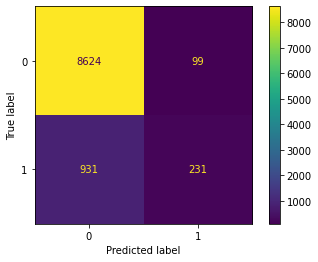

In [93]:
plot_confusion_matrix(gb_grid, x_teste, y_teste)  

In [94]:
precision_score(y_teste, rf_grid.predict(x_teste))

0.4428794992175274

In [95]:
recall_score(y_teste, rf_grid.predict(x_teste))

0.24354561101549052

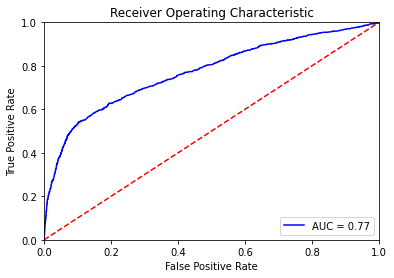

In [99]:


probs = gb_grid_roc.predict_proba(x_teste)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_teste, preds)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Serializar o modelo

In [100]:
 import pickle
 import joblib

In [101]:
gb_grid

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(n_estimators=400,
                                                  random_state=42),
             param_grid={'max_depth': [1, 3, 8], 'min_samples_leaf': [1, 5, 10],
                         'min_samples_split': [1.0, 2],
                         'n_estimators': [10, 20, 50, 200]})

In [102]:
with open("gb_grid.pkl","wb") as modelo:
  pickle.dump(gb_grid, modelo)

In [103]:
joblib.dump(gb_grid, "gb_grid.joblib.pkl")

['gb_grid.joblib.pkl']

Fazendo a leitura do modelo serializado

In [105]:
modelo_pickle = pickle.load(open("gb_grid.pkl","rb"))
modelo_pickle

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(n_estimators=400,
                                                  random_state=42),
             param_grid={'max_depth': [1, 3, 8], 'min_samples_leaf': [1, 5, 10],
                         'min_samples_split': [1.0, 2],
                         'n_estimators': [10, 20, 50, 200]})

In [108]:
modelo_joblib = joblib.load( "gb_grid.joblib.pkl")
modelo_joblib

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(n_estimators=400,
                                                  random_state=42),
             param_grid={'max_depth': [1, 3, 8], 'min_samples_leaf': [1, 5, 10],
                         'min_samples_split': [1.0, 2],
                         'n_estimators': [10, 20, 50, 200]})

Prevendo os valores usando o modelo

In [120]:
teste_predicao = explicativas_modelagem.iloc[:5,:]
teste_predicao

,age,campaign,previous,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,contact_telephone,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_nonexistent,poutcome_success,difficulty_0,difficulty_1,difficulty_2,difficulty_4
0,49,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
1,37,2,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
2,78,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
3,36,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
4,59,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0


In [121]:
resultado_teste = modelo_joblib.predict(teste_predicao)
resultado_teste

array([0, 0, 0, 0, 0])

In [126]:
teste_predicao_target = var_resp.iloc[:5]
teste_predicao_target

0    0
1    0
2    1
3    0
4    0
Name: y, dtype: int64

In [127]:
accuracy_score(teste_predicao_target, resultado_teste)

0.8